In [7]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler, StandardScaler # min/max scaling
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from mapseq_fxns import * # import all functions from this script
# from math import log10
import matplotlib.lines as mlines # needed for custom legend
from scipy import stats
from scipy.stats import mannwhitneyu # nonparametric test
import random
from statsmodels.distributions.empirical_distribution import ECDF # for generating cdfs



%matplotlib inline

In [8]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
out_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/output/'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp


In [9]:
#### load data
with open(in_path +'M194_M220_OMC_bin4.pkl', 'rb') as f:
    omc_bin = pickle.load(f)   

#### load data
with open(in_path +'M194_M220_OMC_countN4.pkl', 'rb') as f:
    omc_countN = pickle.load(f)

In [10]:
# seperate by cell type

omc_type = [sort_by_celltype(omc_countN[i]) for i in range(num_samples)]

# clean-up datasets here
omc_clean = []
for i in range(num_samples):
    omc_clean.append(clean_up_data(omc_type[i]))


omc_pt = [(omc_clean[i][omc_clean[i]['type']=="PT"]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]
omc_it = [(omc_clean[i][omc_clean[i]['type']=="IT"]).drop(["type"], axis=1).reset_index(drop=True) for i in range(num_samples)]



/Users/eisko/github_repos/MAPseq_analysis/mapseq_fxns.py:88: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nodes = replaced.drop(["OMCi"], axis=1).sum(axis=1)
/Users/eisko/github_repos/MAPseq_analysis/mapseq_fxns.py:88: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nodes = replaced.drop(["OMCi"], axis=1).sum(axis=1)
/Users/eisko/github_repos/MAPseq_analysis/mapseq_fxns.py:88: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nodes = replaced.drop(["OMCi"], axis=1).sum(axis=1)
/Users/eisko/

In [11]:

omc_mm = []
omc_st = []
omc_pt_mm = []
omc_pt_st = []
omc_it_mm = []
omc_it_st = []
mice_mm=[]
mice_st=[]
dataset_mm = []
dataset_st = []

for i in range(num_samples):
    if metadata.species[i] == 'MMus':
        omc_mm.append(omc_clean[i])
        omc_pt_mm.append(omc_pt[i])
        omc_it_mm.append(omc_it[i])
        mice_mm.append(mice[i])
        dataset_mm.append(dataset[i])
    else:
        omc_st.append(omc_clean[i])
        omc_pt_st.append(omc_pt[i])
        omc_it_st.append(omc_it[i])
        mice_st.append(mice[i])
        dataset_st.append(dataset[i])

omc_mm_all = pd.concat(omc_mm)
omc_st_all = pd.concat(omc_st)

# preprocessing
Based on above graphs, decided to use median count to normalize ncounts

In [12]:
def dfs_preprocess_counts(df_list, drop=["OMCi", "type"]):
    """preprocess ncounts - normalize to median

    Args:
        df_list (list)  | List of dataframes of ncounts
        drop (list)     | List of columns to drop and not account for when determining median

    returns:
        out_list (list): List of dataframes normalized to dataframe median
    """
    out_list = []
    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)
        vals = df.values.flatten()
        idx = vals.nonzero()
        plot = vals[idx]
        median = np.median(plot)
        out_df = df/median

        for j in range(len(drop)):
            out_df[drop[j]] = df_list[i][drop[j]]
        
        out_list.append(out_df)
    return out_list


# histograms

In [7]:
omc_clean[0]

,OMCi,OMCc,AUD,STR,TH,HY,AMY,SNr,SCm,PG,PAG,BS,type
0,57.103800,137.127453,0.0,42.190510,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,IT
1,96.779518,124.909462,0.0,542.350316,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,IT
2,30.845302,123.762430,0.0,53.676099,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,IT
3,45.428137,111.553123,0.0,103.713328,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,IT
4,2.239510,106.507643,0.0,107.347710,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11739,2.750923,0.000000,0.0,13.041508,0.000000,2.702703,0.0,4.918537,8.248508,0.000000,0.0,0.000000,PT
11740,13.174360,0.000000,0.0,27.391324,14.076010,3.783784,0.0,0.000000,0.877501,2.105263,0.0,0.000000,PT
11741,7.243324,0.000000,0.0,12.511551,1.608687,1.621622,0.0,1.998156,0.000000,2.429150,0.0,0.000000,PT
11742,7.676984,0.000000,0.0,3.801407,1.608687,1.261261,0.0,0.000000,0.000000,2.267206,0.0,0.000000,PT


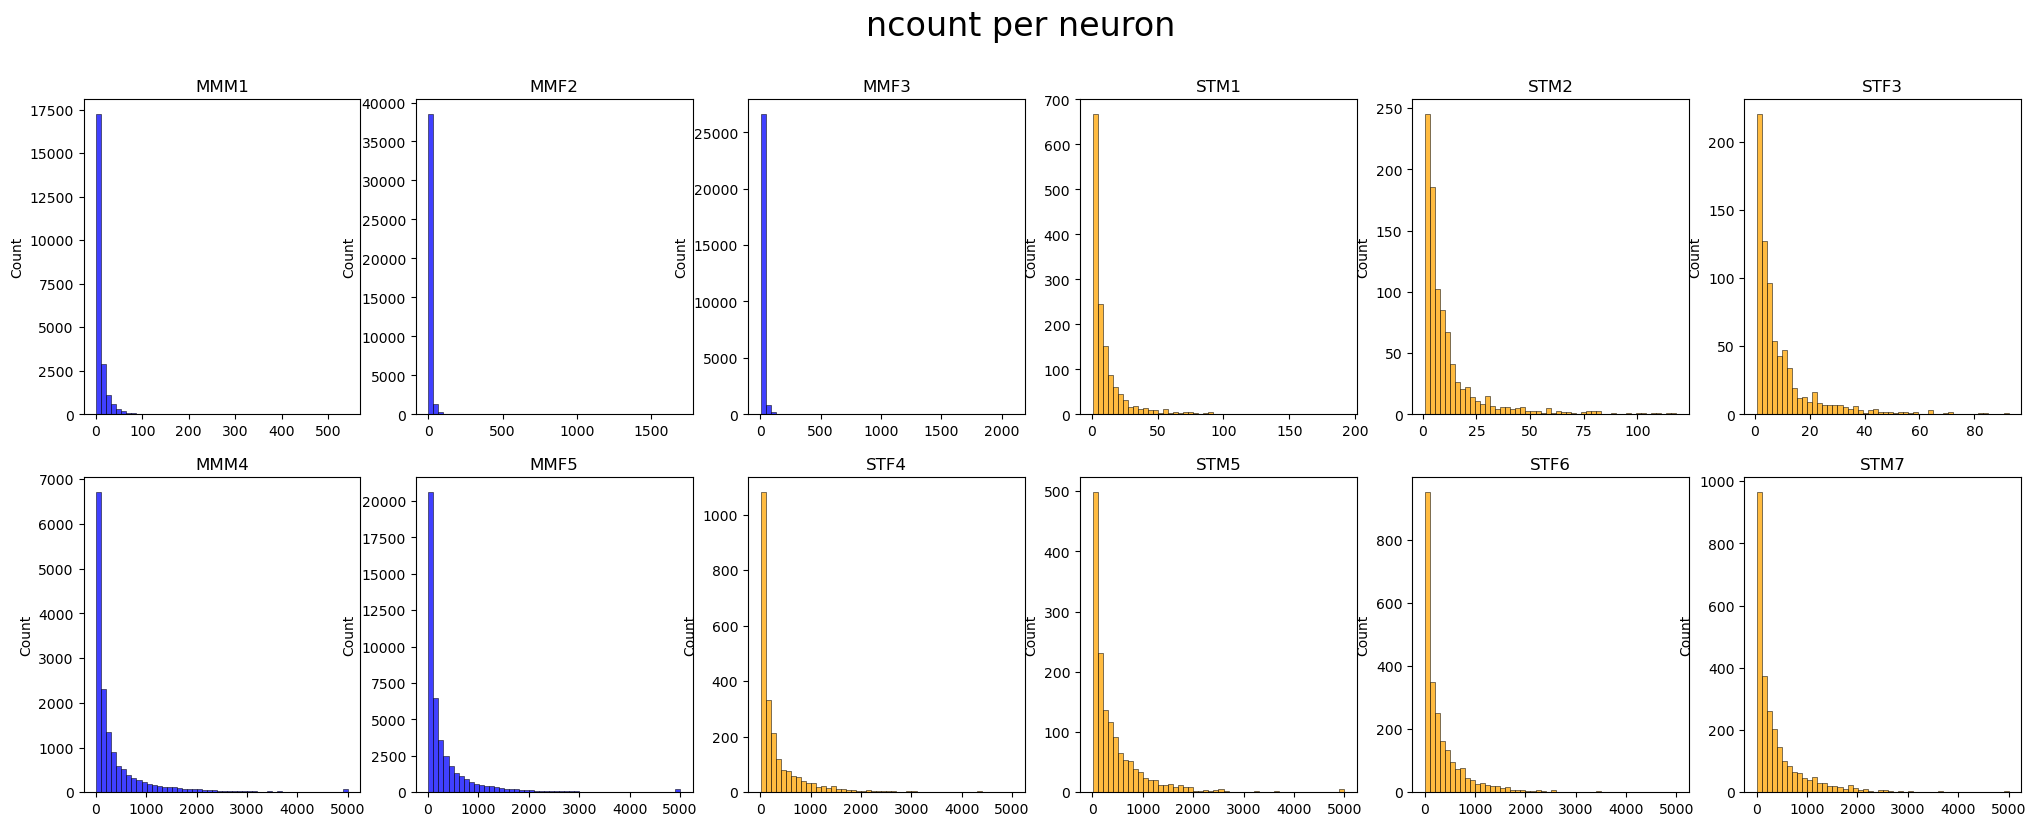

In [12]:
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    df = omc_clean[i].drop(["OMCi", "type"], axis=1)
    vals = df.values.flatten()
    idx = vals.nonzero()
    plot = vals[idx]
    if species[i] == "MMus":
        clr = "blue"
    elif species[i] == "STeg":
        clr="orange"
        

    plot[plot > 5000] = 5000
    sns.histplot(plot, bins = 50,legend=False, color=clr, ax=ax)
    ax.set_title(mice[i])
    # ax.set_xlim(0,5000)
    i+=1
fig.suptitle("ncount per neuron", size=24)
plt.show()

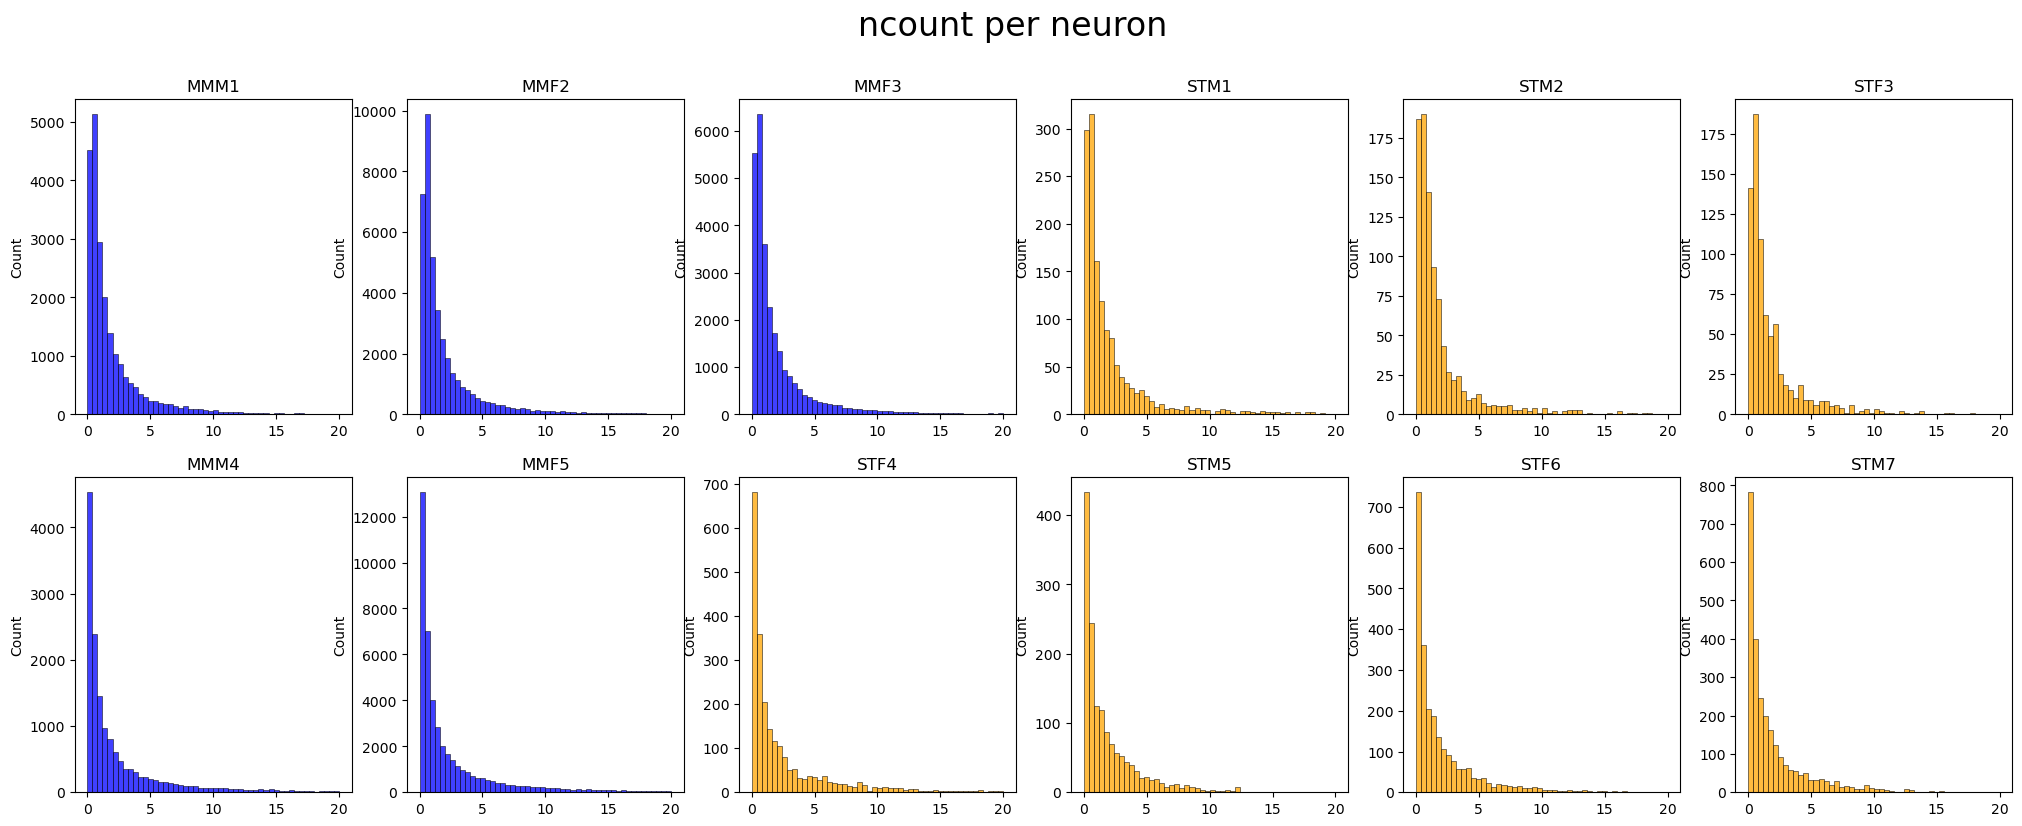

In [9]:
fig, axs = plt.subplots(2,6, figsize=(25,9))
i=0
for ax in axs.flat:
    df = omc_clean[i].drop(["OMCi", "type"], axis=1)
    vals = df.values.flatten()
    idx = vals.nonzero()
    plot = vals[idx]
    median = np.median(plot)
    plot = plot/median
    if species[i] == "MMus":
        clr = "blue"
    elif species[i] == "STeg":
        clr="orange"
        

    # plot[plot > 5000] = 5000
    sns.histplot(plot, bins = 50, binrange=(0,20), legend=False, color=clr, ax=ax)
    ax.set_title(mice[i])
    # ax.set_xlim(0,5000)
    i+=1
fig.suptitle("ncount per neuron", size=24)
plt.show()

# CDF by area

In [13]:
# CDF by area
omc_processed = dfs_preprocess_counts(omc_clean) # note: processing doesn't median normalize OMCi
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


In [20]:
areas

Index(['OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG',
       'BS', 'OMCi', 'type'],
      dtype='object')

In [25]:
areas = omc_processed[0].columns.drop(['BS','type'])
plot_areas = []

for n in range(len(areas)):
    area = areas[n]
    all_bc = []
    # all_x = []
    # all_cdfs = []
    for i in range(num_samples):
        df = omc_processed[i]
        col = df[area]
        col = col[col >0] # only keep nonzeros
        all_bc.append(col)

    all_min = np.concatenate(all_bc).min()
    all_max = np.concatenate(all_bc).max()

    plot = pd.DataFrame(columns=["x", "cdf", "mice", "species", "dataset"])

    for i in range(num_samples):
        col = all_bc[i]
        ecdf = ECDF(col)
        x = np.logspace(np.log10(all_min), np.log10(all_max), num=1000)
        # all_x.append(x)
        y = ecdf(x)
        # all_cdfs.append(y)
        int = pd.DataFrame({"x":x, "cdf":y, "mice":mice[i], "species":species[i], "dataset":dataset[i]})
        plot = pd.concat([plot, int])

    print(area)
    plot_areas.append(plot)


OMCc
AUD
STR
TH
HY
AMY
SNr
SCm
PG
PAG
OMCi


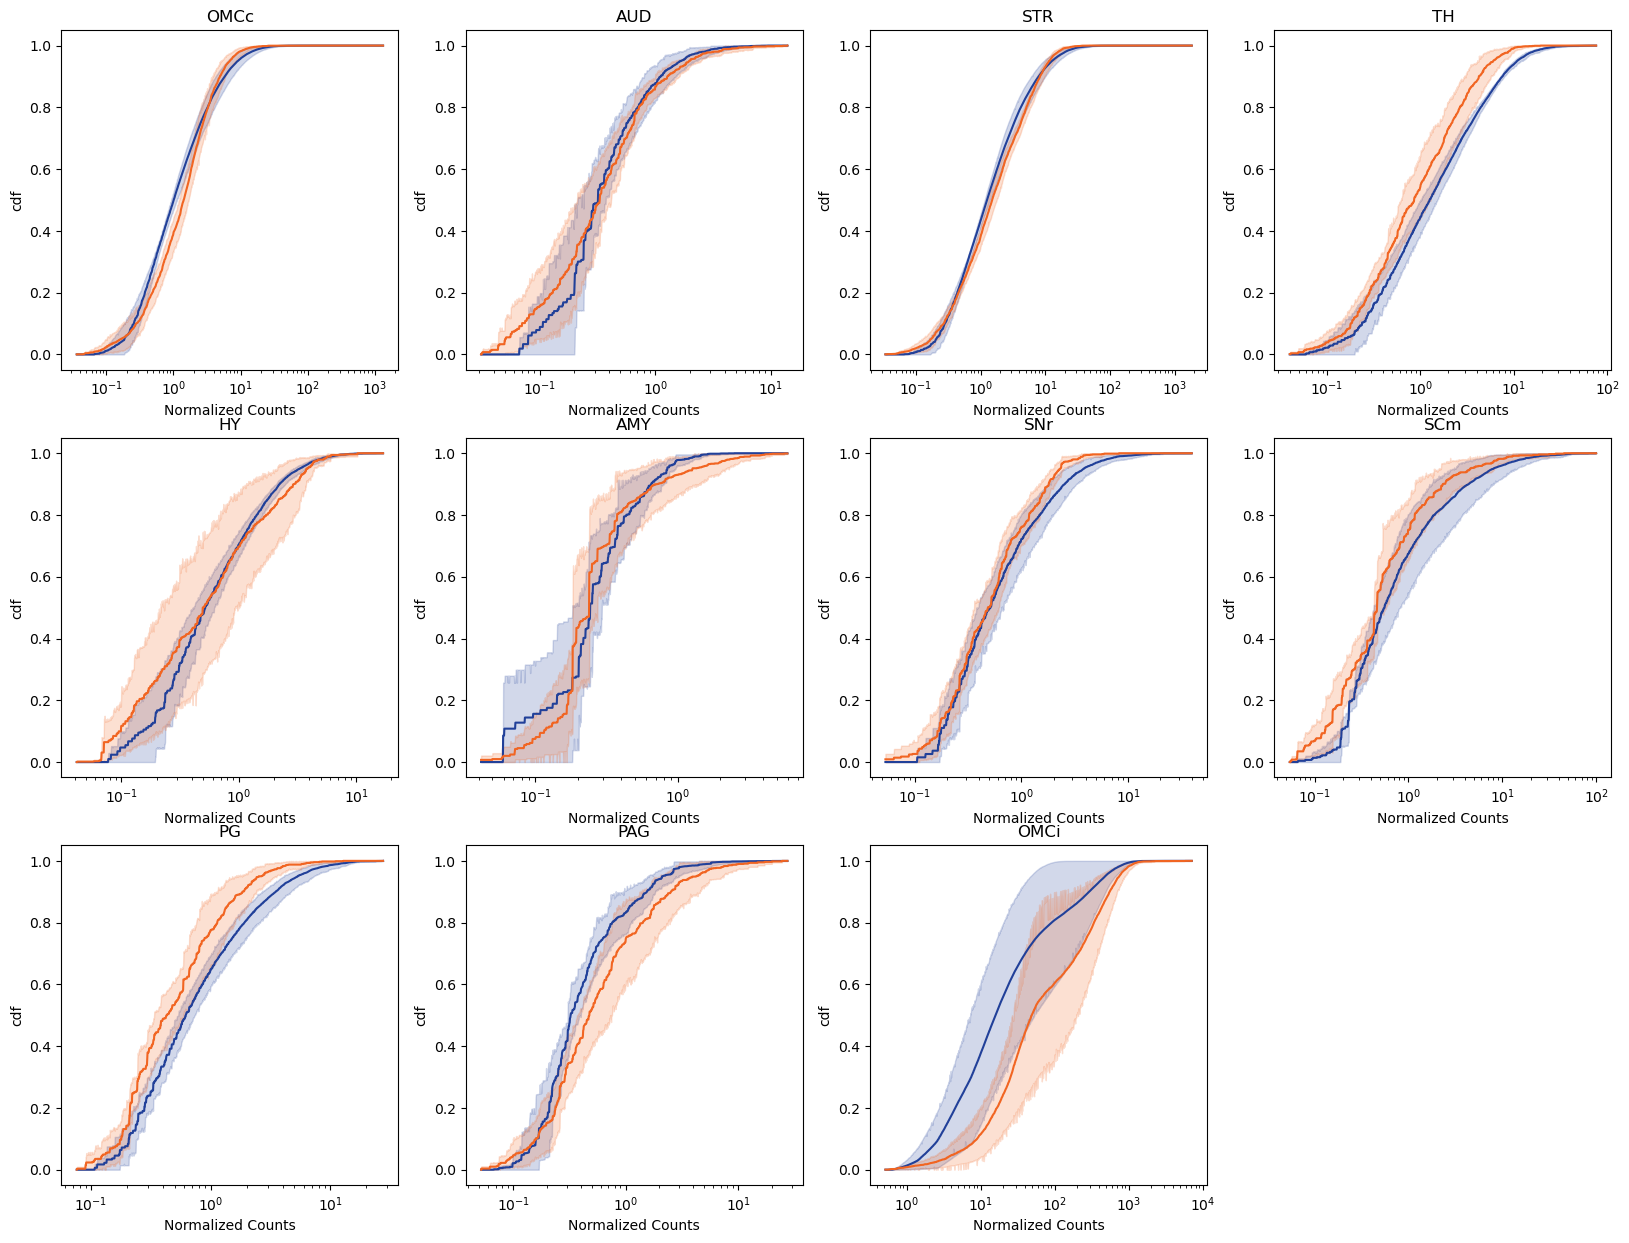

In [28]:
fig, axs = plt.subplots(3,4, figsize=(20,15))

i=0
for ax in axs.flat:
    if i <11:
        plot = plot_areas[i]

        plot_mm = plot[plot["species"] =="MMus"]
        plot_st = plot[plot["species"] =="STeg"]

        sns.lineplot(plot_mm, x="x", y="cdf", color=blue_cmp.colors[255], ax=ax)
        sns.lineplot(plot_st, x="x", y="cdf", color=orange_cmp.colors[255], ax=ax)
        ax.set_xscale("log")
        ax.set_xlabel("Normalized Counts")

        ax.set_title(areas[i])
        i+=1
    else:
        ax.axis('off')

In [31]:
areas

Index(['OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG',
       'OMCi'],
      dtype='object')

In [34]:
# separate into cell types
omc_processed = dfs_preprocess_counts(omc_clean) # note: processing doesn't median normalize OMCi
it_processed = []
pt_processed = []
for i in range(num_samples):
    df = omc_processed[i]
    it = df[df['type'] == "IT"].drop(['TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS',
       'OMCi'], axis=1)
    pt = df[df['type'] == "PT"].drop(['OMCc', 'AUD', 'STR', 'TH', 'HY', 'OMCi'], axis=1)
    it_processed.append(it)
    pt_processed.append(pt)



OMCc
AUD
STR


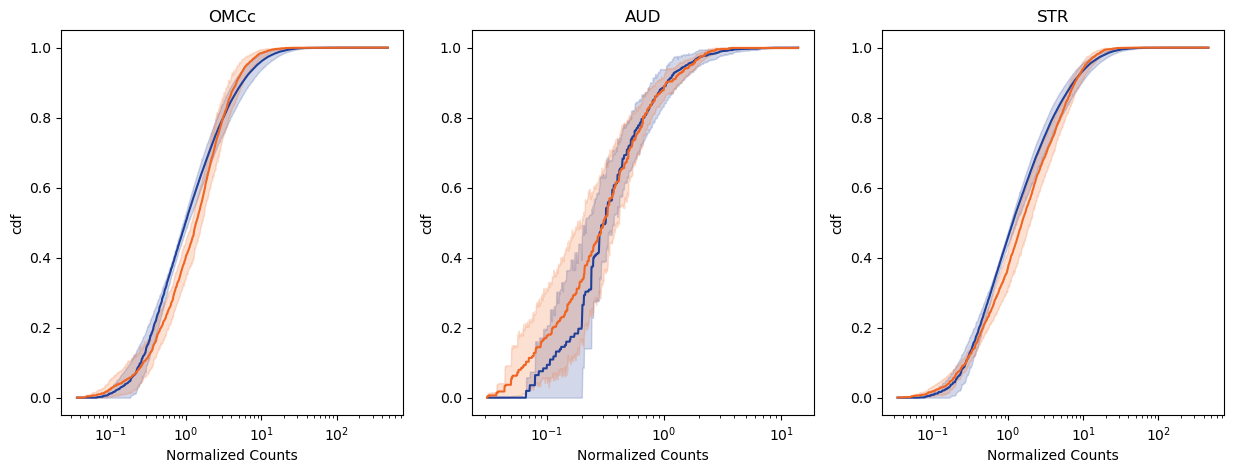

In [36]:
# IT Cells
areas = it_processed[0].columns.drop(['type'])
plot_areas = []


for n in range(len(areas)):
    area = areas[n]
    all_bc = []
    # all_x = []
    # all_cdfs = []
    for i in range(num_samples):
        df = it_processed[i]
        col = df[area]
        col = col[col >0] # only keep nonzeros
        all_bc.append(col)

    all_min = np.concatenate(all_bc).min()
    all_max = np.concatenate(all_bc).max()

    plot = pd.DataFrame(columns=["x", "cdf", "mice", "species", "dataset"])

    for i in range(num_samples):
        col = all_bc[i]
        ecdf = ECDF(col)
        x = np.logspace(np.log10(all_min), np.log10(all_max), num=1000)
        # all_x.append(x)
        y = ecdf(x)
        # all_cdfs.append(y)
        int = pd.DataFrame({"x":x, "cdf":y, "mice":mice[i], "species":species[i], "dataset":dataset[i]})
        plot = pd.concat([plot, int])

    print(area)
    plot_areas.append(plot)

fig, axs = plt.subplots(1,3, figsize=(15,5))

i=0
for ax in axs.flat:
    if i <len(areas):
        plot = plot_areas[i]

        plot_mm = plot[plot["species"] =="MMus"]
        plot_st = plot[plot["species"] =="STeg"]

        sns.lineplot(plot_mm, x="x", y="cdf", color=blue_cmp.colors[255], ax=ax)
        sns.lineplot(plot_st, x="x", y="cdf", color=orange_cmp.colors[255], ax=ax)
        ax.set_xscale("log")
        ax.set_xlabel("Normalized Counts")

        ax.set_title(areas[i])
        i+=1
    else:
        ax.axis('off')

AMY
SNr
SCm
PG
PAG


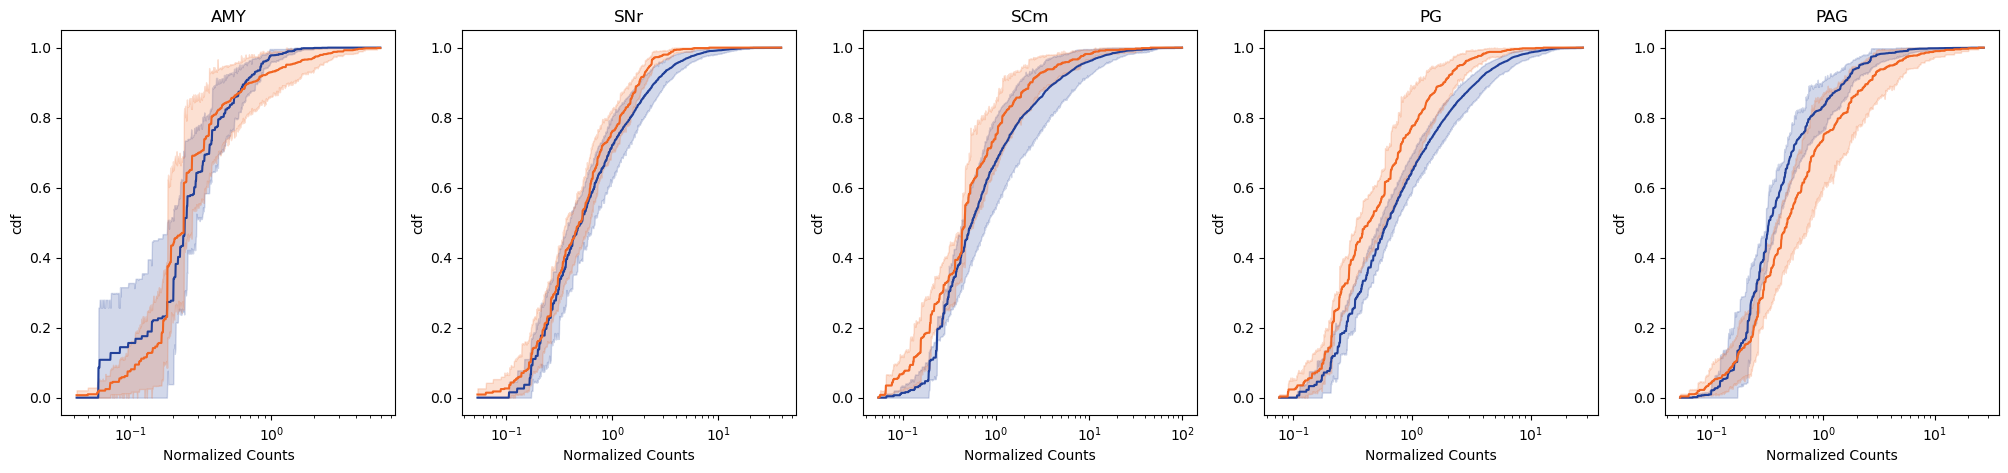

In [38]:
# PT cells
areas = pt_processed[0].columns.drop(['BS','type'])
plot_areas = []


for n in range(len(areas)):
    area = areas[n]
    all_bc = []
    # all_x = []
    # all_cdfs = []
    for i in range(num_samples):
        df = pt_processed[i]
        col = df[area]
        col = col[col >0] # only keep nonzeros
        all_bc.append(col)

    all_min = np.concatenate(all_bc).min()
    all_max = np.concatenate(all_bc).max()

    plot = pd.DataFrame(columns=["x", "cdf", "mice", "species", "dataset"])

    for i in range(num_samples):
        col = all_bc[i]
        ecdf = ECDF(col)
        x = np.logspace(np.log10(all_min), np.log10(all_max), num=1000)
        # all_x.append(x)
        y = ecdf(x)
        # all_cdfs.append(y)
        int = pd.DataFrame({"x":x, "cdf":y, "mice":mice[i], "species":species[i], "dataset":dataset[i]})
        plot = pd.concat([plot, int])

    print(area)
    plot_areas.append(plot)

fig, axs = plt.subplots(1,5, figsize=(25,5))

i=0
for ax in axs.flat:
    if i <len(areas):
        plot = plot_areas[i]

        plot_mm = plot[plot["species"] =="MMus"]
        plot_st = plot[plot["species"] =="STeg"]

        sns.lineplot(plot_mm, x="x", y="cdf", color=blue_cmp.colors[255], ax=ax)
        sns.lineplot(plot_st, x="x", y="cdf", color=orange_cmp.colors[255], ax=ax)
        ax.set_xscale("log")
        ax.set_xlabel("Normalized Counts")

        ax.set_title(areas[i])
        i+=1
    else:
        ax.axis('off')

# heatmaps

In [ ]:
plot = omc_mm_all.sample(1000, random_state=10)
# sort by cell type
plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
plot = plot.sort_values(by=['type']).reset_index(drop=True)


sns.heatmap(plot.drop(['type'], axis=1), norm=LogNorm(), cmap=blue_cmp, cbar=False)
plt.gca().get_yaxis().set_visible(False)
plt.title("mmus norm count")
# plt.savefig(out_path+"mm_single_heatmap.jpeg", dpi=300)

In [ ]:
plot = omc_st_all.sample(1000, random_state=10)
# sort by cell type
plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
plot = plot.sort_values(by=['type']).reset_index(drop=True)

sns.heatmap(plot.drop(['type'], axis=1), norm=LogNorm(), cmap=orange_cmp, cbar=False)
plt.gca().get_yaxis().set_visible(False)
plt.title("Steg ncounts")
# plt.savefig(out_path+"st_single_heatmap.jpeg", dpi=300)

# heatmaps of an individual animal

In [ ]:
fig, axs = plt.subplots(1, len(omc_st), figsize=(20,3))

i=0
for ax in axs.flat:
    plot = omc_st[i]
    plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
    plot = plot.sort_values(by=['type']).reset_index(drop=True)
    sns.heatmap(plot.drop(['type'], axis=1), norm=LogNorm(), cmap=orange_cmp, ax=ax)
    ax.get_yaxis().set_visible(False)
    ax.set_title(mice_st[i])
    i+=1
    
# fig.savefig(out_path+"omc_st_N1_heatmaps.jpeg", dpi=300, bbox_inches="tight")
plt.show()

plot = omc_st[5]
plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
plot = plot.sort_values(by=['type']).reset_index(drop=True)

sns.heatmap(plot.drop(['type'], axis=1), norm=LogNorm(), cmap=orange_cmp)
plt.gca().get_yaxis().set_visible(False)
plt.title(mice_st[5]+ " ncount")
# plt.savefig(out_path + "st_N1_n6454_heatmap.jpeg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, len(omc_mm), figsize=(20,3))

i=0
for ax in axs.flat:
    plot = omc_mm[i]
    plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
    plot = plot.sort_values(by=['type']).reset_index(drop=True)
    sns.heatmap(plot.drop(['type'], axis=1), norm=LogNorm(), cmap=blue_cmp, ax=ax)
    ax.get_yaxis().set_visible(False)
    ax.set_title(mice_mm[i])
    i+=1
    
# fig.savefig(out_path+"omc_mm_N1_heatmaps.jpeg", dpi=300, bbox_inches="tight")
plt.show()

plot = omc_mm[3]
plot = plot.replace({"IT":0.25, "CT":0.5, "PT":0.75})
plot = plot.sort_values(by=['type']).reset_index(drop=True)

sns.heatmap(plot.drop(['type'], axis=1), norm=LogNorm(), cmap=blue_cmp)
plt.gca().get_yaxis().set_visible(False)
plt.title(mice_mm[3]+" ncount")
# plt.savefig(out_path + "MM_N1_n6454_heatmap.jpeg", dpi=300, bbox_inches="tight")
plt.show()

# summary plots

# histograms

In [13]:
def dfs_preprocess_counts(df_list, drop=["OMCi", "type"]):
    """preprocess ncounts - normalize to median

    Args:
        df_list (list)  | List of dataframes of ncounts
        drop (list)     | List of columns to drop and not account for when determining median

    returns:
        out_list (list): List of dataframes normalized to dataframe median
    """
    out_list = []
    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)
        vals = df.values.flatten()
        idx = vals.nonzero()
        plot = vals[idx]
        median = np.median(plot)
        out_df = df/median

        for j in range(len(drop)):
            out_df[drop[j]] = df_list[i][drop[j]]
        
        out_list.append(out_df)
    return out_list


In [14]:
def dfs_to_proportions(df_list, drop=["OMCi", "type"], cell_type=None):
    """Output dataframe of proportions in format that can be plotted with seaborn

    Args:
        df_list (list): 
            - List of dataframes of neurons/BC by areas, must be of num_samples size (12)
        drop (list, optional): 
            - Defaults to ["OMCi", "type"]
            - list of areas/columns to drop before calculating proportions
        cell_type (string, optional): 
            - Specify cell types in df, either IT, CT or PT
            - Defaults to None

    Returns:
        plot_df (pandas_dataframe):
            - returns dataframe in format for seaborn plotting
            - columns = areas, and other metadata
    """

    plot_df = pd.DataFrame(columns=["area", "proportion", "mice", "species", "dataset"])

    if cell_type == "IT":
        drop = ["OMCi", 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']
    elif cell_type == "PT":
        drop = ["OMCi",'OMCc', 'AUD']

    # mice = []
    # species = []
    # dataset = []

    for i in range(num_samples):
        df = df_list[i].drop(drop, axis=1)
        bc_sum = df.sum()
        proportion = bc_sum/df.shape[0]
        df_add = pd.DataFrame({"area":proportion.index.values, "proportion":proportion.values, 
        "mice":mice[i], "species":species[i], "dataset":dataset[i]})
        plot_df = pd.concat([plot_df, df_add])
    
    return plot_df

# ncount/neuron across areas

<AxesSubplot: xlabel='OMCi', ylabel='Count'>

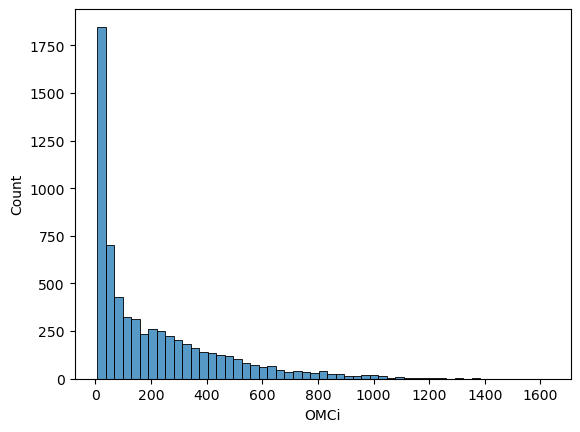

In [21]:
mm3_processed = dfs_preprocess_counts([omc_mm[3]])
df = mm3_processed[0]


sns.histplot(df["OMCi"])


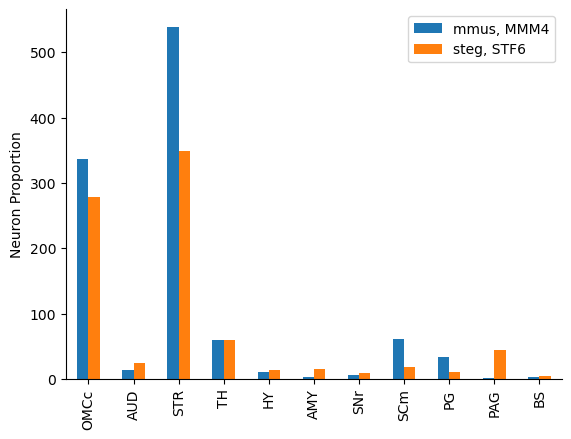

In [15]:
mm3_processed = dfs_process_counts([omc_mm[3]])
mm3_sum = dfs_to_sums(mm3_processed, mi=[mice_mm[3]], sp=["MMus"], ds=[dataset_mm[3]])

st5_processed = dfs_process_counts([omc_st[5]])
st5_sum = dfs_to_sums(st5_processed, mi=[mice_st[5]], sp=["STeg"], ds=[dataset_st[5]])
plot_df = pd.concat([mm3_sum, st5_sum]).reset_index(drop=True)
sns.barplot(plot_df,x="area", y="sum", hue="species")
# plot_df


omc_mm_int = omc_mm[3].drop(["OMCi", "type"], axis=1)
mm_sum = omc_mm_int.sum()
mm_proportion = mm_sum/omc_mm_int.shape[0]

omc_st_int = omc_st[5].drop(["OMCi", "type"], axis=1)
st_sum = omc_st_int.sum()
st_proportion = st_sum/omc_st_int.shape[0]

plot_df = pd.DataFrame(columns=['mmus', 'steg'])
# plot_df
plot_df['mmus'] = mm_proportion
plot_df['steg'] = st_proportion

plot_df.plot(kind='bar')
plt.ylabel("Neuron Proportion")
# plt.xlabel("Node Degree")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(labels=["mmus, "+mice_mm[3], "steg, "+mice_st[5]])

# plt.savefig(out_path+"proj_hist_N1.jpeg", dpi=300, bbox_inches="tight")

In [ ]:
omc_mm_int = omc_mm_all.drop(["type"], axis=1)
mm_sum = omc_mm_int.sum()
mm_proportion = mm_sum/omc_mm_int.shape[0]

omc_st_int = omc_st_all.drop(["type"], axis=1)
st_sum = omc_st_int.sum()
st_proportion = st_sum/omc_st_int.shape[0]

plot_df = pd.DataFrame(columns=['mmus', 'steg'])
# plot_df
plot_df['mmus'] = mm_proportion
plot_df['steg'] = st_proportion


plot_df.plot(kind='bar')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel("Neuron Proportion")
# plt.savefig(out_path+'mm_st_hist.jpeg', dpi=300)

In [ ]:
# create dataframe for plotting proportions
plot_df = dfs_to_proportions(omc_clean)

sns.catplot(plot_df, x="area", y="proportion", hue="species", kind="bar")
# plt.savefig(out_path + "all_hist_bar.jpeg", dpi=300, bbox_inches="tight")
plt.show()

dot_bar_plot(plot_df, "All Cells", xaxis="area", yaxis="proportion", hueaxis="species")
plt.show()

In [ ]:
### IT

# create dataframe for plotting proportions
plot_df = dfs_to_proportions(omc_it, cell_type="IT")

dot_bar_plot(plot_df, "IT cells", xaxis="area", yaxis="proportion", hueaxis="species")
plt.show()

### PT
# create dataframe for plotting proportions
plot_df = dfs_to_proportions(omc_pt, cell_type="PT")

dot_bar_plot(plot_df, "PT cells", xaxis="area", yaxis="proportion", hueaxis="species")
plt.show()

In [ ]:
# all cells
plot_df = dfs_to_proportions(omc_clean)
plot_df = plot_df.rename(columns={'species':"Species", "dataset":"Dataset", 'mice':'mouse'})
individ_node_plot(plot_df, "All Cells", xaxis="area", yaxis="proportion")
plt.show()

# it cells
plot_df = dfs_to_proportions(omc_it, cell_type="IT")
plot_df = plot_df.rename(columns={'species':"Species", "dataset":"Dataset", 'mice':'mouse'})
individ_node_plot(plot_df, "IT Cells", xaxis="area", yaxis="proportion")
plt.show()

# pt cells
plot_df = dfs_to_proportions(omc_pt, cell_type="PT")
plot_df = plot_df.rename(columns={'species':"Species", "dataset":"Dataset", 'mice':'mouse'})
individ_node_plot(plot_df, "PT Cells", xaxis="area", yaxis="proportion")
plt.show()

# Dot Plots

In [ ]:
it_OMC_proportions = []

# OMC proportions
for i in range(num_samples):
    total = omc_it[i].shape[0]
    prop = omc_it[i].sum()/total
    it_OMC_proportions.append(prop)


In [ ]:
# dot plots for individual areas
areas = omc_it[0].columns

all_it_OMC_proportions = []
for area in areas:
    area_proportion = metadata[["mice", "species", "dataset"]]
    area_prop = []
    for i in range(num_samples):
        area_prop.append(it_OMC_proportions[i][area])

    area_proportion['proportion'] = area_prop
    
    all_it_OMC_proportions.append(area_proportion)

In [ ]:
areasi = pd.Series(data=list(range(len(areas))), index=areas)
# areasi

In [ ]:
# all_it_OMC_proportions

In [ ]:
# AUD
i = areasi["AUD"]
fig, ax = plt.subplots()
df = all_it_OMC_proportions[i]
strip = sns.stripplot(data=df, x="species", y="proportion", hue="species", size=10, ax=ax)
point = sns.pointplot(data=df, x="species", y="proportion", hue="species", units='mice', color='black', markers='+', ax=ax) # plots mean and 95 confidence interval:
plt.title("IT - " + areas[i], size=20)
plt.ylim((0)) # make sure y axis starts at 0
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="upper left")
test = mlines.Line2D([], [], color="black", marker="+", linewidth=0, label="mean, 95 CI")
plt.legend(handles=[test])


In [ ]:
# OMCc
i = areasi["OMCc"]
fig, ax = plt.subplots()
df = all_it_OMC_proportions[i]
strip = sns.stripplot(data=df, x="species", y="proportion", hue="species", size=10, ax=ax)
point = sns.pointplot(data=df, x="species", y="proportion", hue="species", units='mice', color='black', markers='+', ax=ax) # plots mean and 95 confidence interval:
plt.title("IT - " + areas[i], size=20)
plt.ylim((0)) # make sure y axis starts at 0
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="upper left")
test = mlines.Line2D([], [], color="black", marker="+", linewidth=0, label="mean, 95 CI")
plt.legend(handles=[test])



df
# plt.savefig(out_path+"it_omcc_dotplot.jpeg", dpi=300, bbox_inches='tight')

In [ ]:
# STR
i = areasi["STR"]

fig, ax = plt.subplots()
df = all_it_OMC_proportions[i]
strip = sns.stripplot(data=df, x="species", y="proportion", hue="species", size=10, ax=ax)
point = sns.pointplot(data=df, x="species", y="proportion", hue="species", units='mice', 
                      color='black', markers='+', ax=ax) # plots mean and 95 confidence interval:
plt.title("IT - " + areas[i], size=20)
plt.ylim((0)) # make sure y axis starts at 0
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="upper left")
test = mlines.Line2D([], [], color="black", marker="+", linewidth=0, label="mean, 95 ci")
plt.legend(handles=[test])


# plt.savefig(out_path+"it_STR_dotplot.jpeg", dpi=300, bbox_inches='tight')

In [ ]:
pt_OMC_proportions = []

# OMC proportions
for i in range(num_samples):
    total = omc_pt[i].shape[0]
    prop = omc_pt[i].sum()/total
    pt_OMC_proportions.append(prop)


# dot plots for individual areas
areas = omc_pt[0].columns

all_pt_OMC_proportions = []
for area in areas:
    area_proportion = metadata[["mice", "species", "dataset"]]
    area_prop = []
    for i in range(num_samples):
        area_prop.append(pt_OMC_proportions[i][area])

    area_proportion['proportion'] = area_prop
    
    all_pt_OMC_proportions.append(area_proportion)

In [ ]:
# PAG
i = areasi["PAG"]

fig, ax = plt.subplots()
df = all_pt_OMC_proportions[i]
strip = sns.stripplot(data=df, x="species", y="proportion", hue="species", size=10, ax=ax)
point = sns.pointplot(data=df, x="species", y="proportion", hue="species", units='mice', color='black', markers='+', ax=ax) # plots mean and 95 confidence interval:
plt.title("PT - " + areas[i], size=20)
plt.ylim((0)) # make sure y axis starts at 0
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="upper left")
test = mlines.Line2D([], [], color="black", marker="+", linewidth=0, label="mean, 95 CI")
plt.legend(handles=[test])

# plt.savefig(out_path+"pt_PAG_dotplot.jpeg", dpi=300, bbox_inches='tight')

In [ ]:
# SNr
i = areasi["SNr"]
fig, ax = plt.subplots()
df = all_pt_OMC_proportions[i]
strip = sns.stripplot(data=df, x="species", y="proportion", hue="species", size=10, ax=ax)
point = sns.pointplot(data=df, x="species", y="proportion", hue="species", units='mice', color='black', markers='+', ax=ax) # plots mean and 95 confidence interval:
plt.title("PT - " + areas[i], size=20)
plt.ylim((0)) # make sure y axis starts at 0
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc="upper left")
test = mlines.Line2D([], [], color="black", marker="+", linewidth=0, label="mean, 95 CI")
plt.legend(handles=[test])

# plt.savefig(out_path+"pt_SNr_dotplot.jpeg", dpi=300, bbox_inches='tight')

# Calculate probs?

In [ ]:
# combine it/pt into one df
omc_mm_it_all = pd.concat(omc_it_mm)
omc_mm_pt_all = pd.concat(omc_pt_mm)
omc_st_it_all = pd.concat(omc_it_st)
omc_st_pt_all = pd.concat(omc_pt_st)


In [ ]:
sim_reps = 1000
sim_sample_size=300

In [ ]:
# create distribution by randomly sampling data
mm_it_probs = est_proj_prob(omc_mm_it_all, reps=sim_reps, sample_size=sim_sample_size)
    
# calculate fraction of projections in singing mice
st_it_probs = est_proj_prob(omc_st_it_all, reps=sim_reps, sample_size=sim_sample_size)

mm_it_probs = pd.DataFrame(mm_it_probs, columns=omc_mm_it_all.columns)
st_it_probs = pd.DataFrame(st_it_probs, columns=omc_st_it_all.columns)


In [ ]:
# create distribution by randomly sampling data
mm_pt_probs = est_proj_prob(omc_mm_pt_all, reps=sim_reps, sample_size=sim_sample_size)
    
# calculate fraction of projections in singing mice
st_pt_probs = est_proj_prob(omc_st_pt_all, reps=sim_reps, sample_size=sim_sample_size)

mm_pt_probs = pd.DataFrame(mm_pt_probs, columns=omc_mm_pt_all.columns)
st_pt_probs = pd.DataFrame(st_pt_probs, columns=omc_st_pt_all.columns)


# try with t test
- parametric test between samples to calc pvalues

In [ ]:
mmus_it_prop = []
steg_it_prop = []
for i in range(len(all_it_OMC_proportions)):
    df = all_it_OMC_proportions[i]
    mm = df[df["species"]=="MMus"]
    mmus_it_prop.append(mm["proportion"])
    st = df[df["species"]=="STeg"]
    steg_it_prop.append(st["proportion"])
mmus_it_array = np.array(mmus_it_prop)
steg_it_array = np.array(steg_it_prop)


In [ ]:

# pd.set_option('display.max_rows', None)
results = stats.ttest_ind(mmus_it_array, steg_it_array, axis=1) # parametric
# results = stats.mannwhitneyu(mmus_it_array, steg_it_array, axis=1) # non-parametric test
p_vals = results[1]
plot = pd.DataFrame({"area":areas, "p-value":p_vals})

plot["mm_mean"] = mmus_it_array.mean(axis=1)
plot["st_mean"] = steg_it_array.mean(axis=1)
# plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"]) # modulation index
plot["fold_change"] = plot["st_mean"]/(plot["mm_mean"])
plot["log2_fc"] = np.log2(plot["fold_change"])
plot["nlog10_p"] = -np.log10(plot["p-value"])

# drop irrelevant rows
non_it = ["OB", "OMCi", "ACAi", "ACAc", "TH", "HY", "AMY", "HIP", "SNr", "SCm", "PG", "PAG", "BS"]
idx = plot["area"].isin(non_it)
plot = plot[~idx].reset_index(drop=True)


plot



In [ ]:

df = plot

x=df.log2_fc
y=df.nlog10_p

plt.scatter(x,y, s=25)
# plt.xlim([-1,1])
# plt.ylim([-0.1,4])
plt.axline((0, 0), (0, 1),linestyle='--', linewidth=0.5)
plt.axline((0, 0), (1, 0),linestyle='--', linewidth=0.5)
plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
plt.text(-0.1, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.75)
plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5, linewidth=0.5)
plt.text(-0.1, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.75)


for i in range(df.shape[0]):
    plt.text(x=df.log2_fc[i]+0.01,y=df.nlog10_p[i]+0.01,s=df.area[i], 
          fontdict=dict(color='black',size=10))


plt.title("OMC - IT")
plt.xlabel('log2(fold change)')
plt.ylabel('-log10(p-value)')
# plt.savefig(out_path+'omc_it_volcano.jpg',dpi=300, bbox_inches='tight')
# plt.savefig(out_path+'omc_it_volcano.svg',dpi=300, bbox_inches='tight')

In [ ]:
mmus_pt_prop = []
steg_pt_prop = []
for i in range(len(all_pt_OMC_proportions)):
    df = all_pt_OMC_proportions[i]
    mm = df[df["species"]=="MMus"]
    mmus_pt_prop.append(mm["proportion"])
    st = df[df["species"]=="STeg"]
    steg_pt_prop.append(st["proportion"])
mmus_pt_array = np.array(mmus_pt_prop)
steg_pt_array = np.array(steg_pt_prop)



In [ ]:

# pd.set_option('display.max_rows', None)
results = stats.ttest_ind(mmus_pt_array, steg_pt_array, axis=1)
# results = stats.mannwhitneyu(mmus_it_array, steg_it_array, axis=1) # non-parametric test
p_vals = results[1]
plot = pd.DataFrame({"area":areas, "p-value":p_vals})

plot["mm_mean"] = mmus_pt_array.mean(axis=1)
plot["st_mean"] = steg_pt_array.mean(axis=1)
# plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"])
plot["fold_change"] = plot["st_mean"]/(plot["mm_mean"])
plot["log2_fc"] = np.log2(plot["fold_change"])
plot["nlog10_p"] = -np.log10(plot["p-value"])

# drop irrelevant rows
non_pt = ["OB", "OMCi", "ACAi", "ACAc", "HIP"]
idx = plot["area"].isin(non_pt)
plot = plot[~idx].reset_index(drop=True)

plot

In [ ]:





df = plot

x=df.log2_fc
y=df.nlog10_p

plt.scatter(x,y, s=25)
# plt.xlim([-1,1])
# plt.ylim([-0.1,4])
plt.axline((0, 0), (0, 1),linestyle='--', linewidth=0.5)
plt.axline((0, 0), (1, 0),linestyle='--', linewidth=0.5)
plt.axline((0, -np.log10(0.05)), (1,  -np.log10(0.05)),linestyle='--', color='r', alpha=0.75, linewidth=0.5)
plt.text(-0.1, -np.log10(0.05)+.015, 'p<0.05', color='r', alpha=0.75)
plt.axline((0, -np.log10(0.01)), (1,  -np.log10(0.01)),linestyle='--', color='r', alpha=0.5, linewidth=0.5)
plt.text(-0.1, -np.log10(0.01)+.015, 'p<0.01', color='r', alpha=0.75)


for i in range(df.shape[0]):
    plt.text(x=df.log2_fc[i]+0.01,y=df.nlog10_p[i]+0.01,s=df.area[i], 
          fontdict=dict(color='black',size=10))


plt.title("OMC - PT")
plt.xlabel('Log2(fold change)')
plt.ylabel('-log10(p-value)')
# plt.savefig(out_path+'omc_pt_volcano.jpg',dpi=300, bbox_inches='tight')
# plt.savefig(out_path+'omc_pt_volcano.svg',dpi=300, bbox_inches='tight')
